In [1]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import findspark
import numpy as np

from datetime import datetime, timedelta, date
### This program requires a local installation of APACHE SPARK to run

# Start Spark Session
findspark.init('C:\Spark\spark-3.2.2-bin-hadoop2.7')
import pyspark
from pyspark import SparkFiles
from pyspark.sql.functions import to_date, to_timestamp
from getpass import getpass


# Build Spark Session
### IMPORTANT: MAKE SURE THAT spark.config has memory set to 16GB or larger!
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Qwest-Analytics-Dashboard-and-ML-Model").config("spark.jars", "C:\Spark\spark-3.2.2-bin-hadoop2.7\jars\postgresql-42.5.0.jar").getOrCreate()

In [2]:
# ### THIS IS THE FINAL DATABASE PULL, DO NOT RUN UNTIL OPTIMIZATIONS AND DATA CLEANING HAVE FINISHED ###

# # Connecting to database and exporting data

# #Store environmental variables
# password = getpass('Enter DataBase Password: ')

# #Configure for RDS
# mode = 'append'
# jdbc_url="jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database"
# config = {"user":"postgres", 
#           "password": password, 
#           "driver":"org.postgresql.Driver"}

# # Load the ProgrammaticData.csv which contains features and fill rate
# programmatic_data_df = spark.read.format("jdbc").options(
#          url='jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database',
#          dbtable='programmatic_data',
#          user='postgres',
#          password=password,
#          driver='org.postgresql.Driver').load()

# programmatic_data_df.show()
# programmatic_data_df.printSchema()

In [4]:
### PROVISONAL DATABASE ONLY.  DELETE IN FINAL VERSION.  FOR TESTING ONLY ###
programmatic_data = pd.read_csv('Resources/Clean_Advertising_Data_v4.csv')
programmatic_data_df = pd.DataFrame(programmatic_data)

# programmatic_data_df = programmatic_data_df.loc[programmatic_data_df['operator'] == 'Op_003']
# programmatic_data_df
# This is a semi-cleaned dataset and is for one operator in the dataset

In [23]:
# In order to convert date to an integer or float, we need to determine how many days from some given day for the data we want to collect.

programmatic_data_df['date'] = programmatic_data_df['date'].apply(pd.to_datetime)
programmatic_data_df = programmatic_data_df.sort_values(by='date', ascending=True)
programmatic_data_df

,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,impressions,revenue,CPM,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration
0,2022-01-01,India,Asia,Op_002,Channel_001,0.01,1406,73870,574,110,72,0.27,3.750000,89.36,-0.983885,1.44,-0.340278,0.95
55,2022-01-01,Denmark,Europe,Op_002,Channel_002,0.00,6,326,0,0,0,0.00,0.000000,200.00,-1.000000,0.00,NaN,0.00
79,2022-01-01,Sweden,Europe,Op_002,Channel_001,0.06,2109,143151,7554,1674,777,7.11,9.150579,273.57,-0.871916,35.04,-0.535959,16.26
78,2022-01-01,Switzerland,Europe,Op_007,Channel_002,0.00,162,7202,2,2,2,0.02,10.000000,162.96,-0.998159,0.30,0.000000,0.30
77,2022-01-01,Spain,Europe,Op_002,Channel_003,0.00,5820,335084,794,156,84,1.18,14.047619,154.16,-0.991308,1.34,-0.462687,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41117,2022-10-25,Algeria,Africa,Op_007,Channel_002,0.00,4,336,32,0,0,0.00,0.000000,240.00,-1.000000,0.00,NaN,0.00
41116,2022-10-25,Morocco,Africa,Op_007,Channel_002,0.00,3,252,24,0,0,0.00,0.000000,360.00,-1.000000,0.00,NaN,0.00
41134,2022-10-25,United Kingdom,Europe,Op_007,Channel_003,0.11,41,3798,2586,160,19,0.37,19.473684,59.63,-0.046956,56.83,-0.879817,6.83
41112,2022-10-25,Slovakia,Europe,Op_007,Channel_002,0.00,2,122,8,0,0,0.00,0.000000,120.00,-1.000000,0.00,NaN,0.00


In [29]:
# isolate the needed columns and do datetime to int conversion
ml_df = programmatic_data_df[['date', 'revenue']]
ml_df['date_from'] = (ml_df['date'] - pd.to_datetime('2022-01-01')).dt.days.astype('int16')
# # convert to integer
# ml_df['date_from'] = (ml_df['date_from'] / np.timedelta64(1, 'D')).astype(int)
ml_df.dtypes

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_32496\951113231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_df['date_from'] = (ml_df['date'] - pd.to_datetime('2022-01-01')).dt.days.astype('int16')


date         datetime64[ns]
revenue             float64
date_from             int16
dtype: object

In [30]:
ml_df = ml_df.groupby('date_from').sum('revenue').reset_index()
ml_df

,date_from,revenue
0,0,222.12
1,1,322.10
2,2,346.21
3,3,696.35
4,4,776.13
...,...,...
293,293,1066.99
294,294,1287.28
295,295,1404.01
296,296,1104.33


In [ ]:
### ADDITIONAL DATA CLEANING AND PROCESSING?

# modify date?
# Country?
# how can the bid features be used?  Does this require neural network?
# for now build revenue prediction linear regression, but later lets see if we can provide more insight.

# need to separate into operators.  Dependant variable date, and independent variable revenue.


In [31]:
#reformat data to accept scikit library, x data is now in ([[value], [value]...[value]]) format
x=ml_df.date_from.values.reshape(-1,1)
x.shape

y=ml_df.revenue

In [32]:
#instantiate variable model with LinearRegression function, and fit x,y values.  .predict() function will accept x where x equals a number ([[#]])
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)
# prints number of points in prediction model
print(y_pred.shape)

(298,)


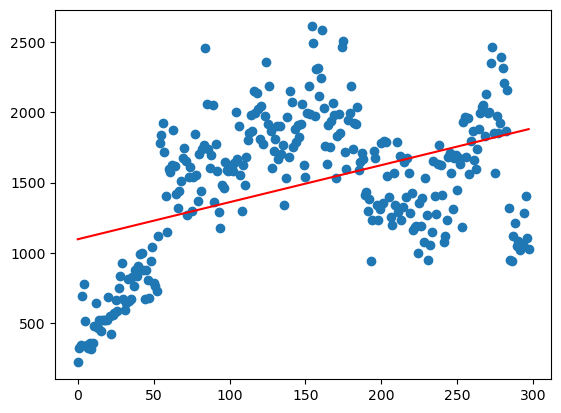

In [33]:
# plot the linear regression on the scatter plot
plt.scatter(x,y)
plt.plot(x, y_pred, color="red")
plt.show()

In [34]:
# get values of linear regression formula
print(model.coef_)
print(model.intercept_)

### THIS PROVISIONAL ML MODEL IS A BASIC linear regression model.  Further EDA might reveal higher order variables that can utilize non-linear functions that may predict price better.
### EDA for this dataset is still in progress.  Potentially a neural network model may be required.

[2.63341036]
1097.5155417386818
